In [1]:
from __future__ import print_function
from PIL import Image
from grpc.beta import implementations
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2
import requests
import numpy as np
# from StringIO import StringIO
from io import StringIO
from io import BytesIO

In [10]:
!pip install /pylib/package/opencv_python-4.2.0.34-cp36-cp36m-manylinux1_x86_64.whl
# !ls "/pylib"

Processing /pylib/package/opencv_python-4.2.0.34-cp36-cp36m-manylinux1_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
!pip install opencv_python

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
# !apt-get update
# !apt-get install -y libsm6 libxext6 libxrender-dev
# !pip install opencv-python

In [2]:
import cv2

In [3]:
image_file = "female_1409.jpg"

In [4]:
def load_test_data(image_path, size=256):
    img = cv2.imread(image_path, flags=cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, dsize=(size, size))

    img = np.expand_dims(img, axis=0)
    img = img/127.5 - 1

    return img

In [5]:
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def inverse_transform(images):
    return ((images+1.) / 2) * 255.0


def imsave(images, size, path):
    images = merge(images, size)
    images = cv2.cvtColor(images.astype('uint8'), cv2.COLOR_RGB2BGR)

    return cv2.imwrite(path, images)

In [8]:
image = np.array(Image.open(image_file))
height = image.shape[0]
width = image.shape[1]
print("Image shape:", image.shape)

Image shape: (256, 256, 3)


In [10]:
height

256

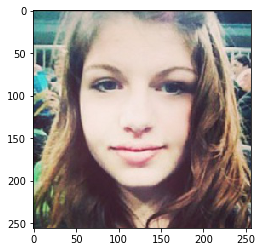

In [9]:
plt.imshow(image)
plt.show()

In [20]:
server = '192.168.62.70:9000'
host, port = server.split(':')

In [21]:
# create the RPC stub
channel = implementations.insecure_channel(host, int(port))
stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)
# create the request object and set the name and signature_name params
request = predict_pb2.PredictRequest()
request.model_spec.name = 'ugatit'
request.model_spec.signature_name = 'predict_images'

/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


In [22]:
request.inputs['images'].CopyFrom(tf.make_tensor_proto(image.astype(dtype=np.float32), shape=[1, height, width, 3]))

In [23]:
# sync requests
result_future = stub.Predict(request, 30.)

# For async requests
# result_future = stub.Predict.future(request, 10.)
# result_future = result_future.result()

In [63]:
# print(repr(result_future))
# result_future
# print(result_future["conv_images"].dtype)
print(result_future["conv_images"].tensor_shape.dim[1].size)
print(result_future["conv_images"].tensor_shape.dim[2].size)
print(result_future["conv_images"].tensor_shape.dim[3].size)

TypeError: 'PredictResponse' object is not subscriptable

In [52]:
float_output = np.array(result_future.outputs['conv_images'].float_val)
height = result_future.outputs['conv_images'].tensor_shape.dim[1].size
width = result_future.outputs['conv_images'].tensor_shape.dim[2].size
float_output = np.reshape(float_output, (height, width,3))
float_output

array([[[-0.87559253,  0.15217564,  0.39405042],
        [-0.87452489,  0.15854266,  0.40020347],
        [-0.87194252,  0.1506674 ,  0.41269231],
        ...,
        [-0.92570406, -0.89226323, -0.72252947],
        [-0.91946882, -0.88450497, -0.7003814 ],
        [-0.91947794, -0.8785665 , -0.69049984]],

       [[-0.87478346,  0.16530859,  0.4081991 ],
        [-0.87620664,  0.17397985,  0.41647032],
        [-0.87285954,  0.16825075,  0.42390928],
        ...,
        [-0.9233799 , -0.88804084, -0.73383617],
        [-0.91795814, -0.88463807, -0.71324641],
        [-0.91862649, -0.88227797, -0.7095148 ]],

       [[-0.87023836,  0.20535119,  0.4244805 ],
        [-0.87018096,  0.21322532,  0.42832434],
        [-0.86486775,  0.20419483,  0.43247256],
        ...,
        [-0.92156959, -0.88684189, -0.73200321],
        [-0.91706294, -0.88286757, -0.71662867],
        [-0.91832036, -0.87706304, -0.71016335]],

       ...,

       [[-0.88493323, -0.73453373, -0.75578815],
        [-0

In [53]:
float_output.shape

(256, 256, 3)

In [54]:
output_inverse = inverse_transform(float_output)
output_inverse

array([[[ 15.86195245, 146.90239348, 177.74142846],
        [ 15.99807635, 147.71418951, 178.52594197],
        [ 16.32732868, 146.71009339, 180.11826932],
        ...,
        [  9.4727321 ,  13.73643771,  35.37749246],
        [ 10.26772544,  14.72561583,  38.20137173],
        [ 10.2665627 ,  15.4827708 ,  39.46127012]],

       [[ 15.96510932, 148.57684582, 179.54538547],
        [ 15.78365386, 149.6824307 , 180.59996568],
        [ 16.21040896, 148.9519712 , 181.54843278],
        ...,
        [  9.769063  ,  14.27479282,  33.93588781],
        [ 10.4603371 ,  14.70864594,  36.56108335],
        [ 10.37512287,  15.00955939,  37.03686342]],

       [[ 16.54460862, 153.68227657, 181.62126347],
        [ 16.55192703, 154.6862283 , 182.11135358],
        [ 17.22936228, 153.53484068, 182.640251  ],
        ...,
        [  9.99987781,  14.42765862,  34.16959047],
        [ 10.57447538,  14.93438423,  36.12984449],
        [ 10.41415438,  15.67446291,  36.95417225]],

       ...,

      

In [55]:
output_inverse.shape

(256, 256, 3)

In [56]:
output_cvt = cv2.cvtColor(output_inverse.astype('uint8'), cv2.COLOR_RGB2BGR)
output_cvt

array([[[177, 146,  15],
        [178, 147,  15],
        [180, 146,  16],
        ...,
        [ 35,  13,   9],
        [ 38,  14,  10],
        [ 39,  15,  10]],

       [[179, 148,  15],
        [180, 149,  15],
        [181, 148,  16],
        ...,
        [ 33,  14,   9],
        [ 36,  14,  10],
        [ 37,  15,  10]],

       [[181, 153,  16],
        [182, 154,  16],
        [182, 153,  17],
        ...,
        [ 34,  14,   9],
        [ 36,  14,  10],
        [ 36,  15,  10]],

       ...,

       [[ 31,  33,  14],
        [ 31,  34,  15],
        [ 32,  35,  15],
        ...,
        [ 24,  53,  54],
        [ 17,  39,  42],
        [ 27,  57,  59]],

       [[ 32,  35,  14],
        [ 32,  35,  15],
        [ 33,  36,  15],
        ...,
        [ 15,  32,  33],
        [ 10,  22,  23],
        [ 21,  43,  45]],

       [[ 32,  34,  14],
        [ 33,  35,  15],
        [ 34,  36,  15],
        ...,
        [  9,  21,  21],
        [  7,  16,  17],
        [ 16,  34,  35]]

In [57]:
output_cvt.shape

(256, 256, 3)

In [59]:
cv2.imwrite('output.jpg', output_cvt)

True

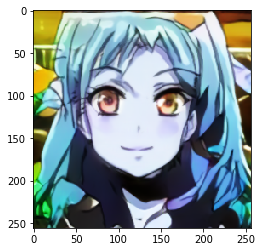

In [60]:
plt.imshow(output_cvt)
plt.show()

In [24]:
# get the results
output = np.array(result_future.outputs['conv_images'].int64_val)
height = result_future.outputs['conv_images'].tensor_shape.dim[1].size
width = result_future.outputs['conv_images'].tensor_shape.dim[2].size

# image_mask = np.reshape(output, (height, width))
# plt.imshow(image_mask)
# plt.show()

ValueError: cannot reshape array of size 0 into shape (256,256)

# function

In [70]:
# server = '192.168.62.70:9000'
# image
def ugatit_grpc(server,image):
    height = image.shape[0]
    width = image.shape[1]
    print("Image shape:", image.shape)
      
    host, port = server.split(':')
    channel = implementations.insecure_channel(host, int(port))
    stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)
    # create the request object and set the name and signature_name params
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'ugatit'
    request.model_spec.signature_name = 'predict_images'
    request.inputs['images'].CopyFrom(tf.make_tensor_proto(image.astype(dtype=np.float32), shape=[1, 256, 256, 3]))

    # sync requests
    result_future = stub.Predict(request, 30.)

    float_output = np.array(result_future.outputs['conv_images'].float_val)
    height = result_future.outputs['conv_images'].tensor_shape.dim[1].size
    width = result_future.outputs['conv_images'].tensor_shape.dim[2].size
    float_output = np.reshape(float_output, (height, width,3))

#     output_inverse = inverse_transform(float_output)
    output_inverse = ((float_output+1.) / 2) * 255.0
    
    return output_inverse.astype('uint8')

Image shape: (256, 256, 3)


/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


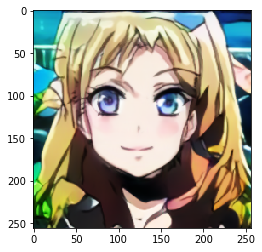

In [71]:
server = '192.168.62.70:9000'

image_file = "female_1409.jpg"
image = np.array(Image.open(image_file))
 
conv_image = ugatit_grpc(server, image)
 
# save to file
output_bgr = cv2.cvtColor(conv_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_bgr.jpg', output_cvt)

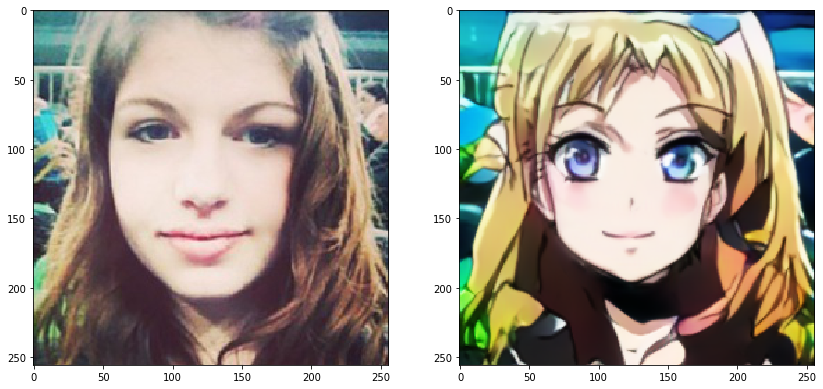

In [72]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
plt.imshow(image, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(conv_image, 'gray', interpolation='none')
# plt.imshow(image_mask, 'jet', interpolation='none', alpha=0.7)
plt.show()